In [1]:
import numpy as np
from scipy import stats
from scipy import signal
import math
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
from os.path import sep

In [2]:
from fly2p_function_TQ.imaging_2p_fixed_heading_period_analysis import find_stop_period_on_heading,PVA_during_stopPeriod,forwrad_speed_during_stopPeriod,bump_amplitude_during_stopPeriod,calculate_angle_difference_between_two_time_point
from fly2p_function_TQ.imaging_2p_fictrac_imaging_alignment import fictrack_signal_decoding
from fly2p_function_TQ.imaging_2p_PVA_functions import calcualteBumpAmplitude

In [3]:
#Read the imaging/behavior data after preprocessing
pd_imaging_behavior_preprocessed = pd.read_csv('/home/tianhaoqiu/Documents/GitHub/2p_analysis/preprocessing_output/normalized/PENb_EB/TQfly058-007-imaging-normalized.csv')
pd_imaging_behavior_preprocessed

Time_Stamp    F_Roi_1    F_Roi_2    F_Roi_3    F_Roi_4    F_Roi_5   
0        0.00000  27.198777  15.449991  17.030219  12.334413  18.223508  \
1        0.11658  24.883115  22.393067  17.225367  11.707616  18.412185   
2        0.23316  32.784596  18.336575  17.203158  15.222203  18.902477   
3        0.34974  28.410615  17.324538  14.884635  11.729797  19.426499   
4        0.46632  31.830368  19.711992  19.977606  11.538854  14.293047   
...          ...        ...        ...        ...        ...        ...   
2569   299.49402  19.405842  17.587314  17.288185  13.546967  19.827515   
2570   299.61060  17.340699  14.983073  20.892678  12.908975  15.306213   
2571   299.72718  11.030675  11.734765  18.512305  11.021437  15.021723   
2572   299.84376  18.203287  15.182742  18.030109  13.102369  15.526452   
2573   299.96034  14.941305  14.382564  21.320109  13.113227  14.584665   

        F_Roi_6    F_Roi_7    F_Roi_8  dFF_Roi_1  ...  PVA_Radian_offset   
0     19.500760  25.751142  19.685966   0.478154  ...          -0.985546  \
1     21.029094  29.993038  20.003513   0.599494  ...          -0.767620   
2     21.585871  20.566356  22.173476   0.619551  ...          -0.748639   
3     23.342128  22.608991  23.769371   0.660716  ...          -0.603160   
4     18.695033  27.533169  18.565500   0.619551  ...          -0.509357   
...         ...        ...        ...        ...  ...                ...   
2569  11.590674  10.647885   9.194761   0.253630  ...           1.812241   
2570  12.322674  13.046091  11.558280   0.234904  ...           2.558816   
2571   9.441254  15.497811   9.993514   0.230368  ...           0.848065   
2572  11.410750  11.597787  12.547072   0.178609  ...           1.866470   
2573  11.406385  13.508208   8.822765   0.178609  ...           1.575371   

       PVA_Angle  Angular_Velocity  Bar_Position/Heading   
0     -56.467631         -0.734078             -2.102413  \
1     -43.981392         -0.862471             -2.187992   
2     -42.893838          0.394509             -2.303507   
3     -34.558502          0.924648             -2.096008   
4     -29.184000          0.953931             -2.087916   
...          ...               ...                   ...   
2569  103.833769         -0.053147             -0.855772   
2570  146.609340          0.015179             -0.873527   
2571   48.590560          0.046356             -0.852233   
2572  106.940845         -0.189116             -0.862719   
2573   90.262114         -0.288284             -0.896327   

      Unwrapped_Bar_Position/Heading  Unwrapped_Radian  Integrated_x   
0                          -2.102413         -0.985546     -0.489323  \
1                          -2.187992         -0.767620     -0.515077   
2                          -2.303507         -0.748639     -0.509987   
3                          -2.096008         -0.603160     -0.522615   
4                          -2.087916         -0.509357     -0.548439   
...                              ...               ...           ...   
2569                       -0.855772        -10.754129     -0.744539   
2570                       -0.873527        -10.007555     -0.710288   
2571                       -0.852233        -11.718305     -0.779503   
2572                       -0.862719        -10.699901     -0.718155   
2573                       -0.896327        -10.991000     -0.736583   

      Integrated_y  PVA_strength  Bump_amplitude  
0         0.222937      0.951457        0.630709  
1         0.233749      1.078727        0.608510  
2         0.248764      1.099189        0.559823  
3         0.231562      1.152078        0.545578  
4         0.205031      1.087131        0.628303  
...            ...           ...             ...  
2569      0.079705      0.313128        0.244624  
2570      0.069327      0.238208        0.250635  
2571      0.096648      0.149667        0.151261  
2572      0.058598      0.216659        0.245681  
2573      0.068258      0.290381        0.231

In [4]:
trial_type = 0

In [5]:
volume_cycle = len(pd_imaging_behavior_preprocessed)
volume_time = pd_imaging_behavior_preprocessed['Time_Stamp'][1]
volume_rate = 1/volume_time
time_array_imaging = np.arange(volume_cycle)/volume_rate

In [6]:
PVA_Unwrapped_Radian = pd_imaging_behavior_preprocessed['Unwrapped_Radian']
PVA_Angle = pd_imaging_behavior_preprocessed['PVA_Angle']
Angular_velocity = pd_imaging_behavior_preprocessed['Angular_Velocity']
integrated_x = pd_imaging_behavior_preprocessed['Integrated_x']
PVA_strength = pd_imaging_behavior_preprocessed['PVA_strength']
Bump_amplitude = pd_imaging_behavior_preprocessed['Bump_amplitude']
Unwrapped_heading = pd_imaging_behavior_preprocessed['Unwrapped_Bar_Position/Heading']

In [7]:
PVA_Unwrapped_Radian_no_series = np.zeros(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian']))
PVA_Angle_no_series = np.zeros(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian']))
Angular_velocity_no_series = np.zeros(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian']))
integrated_x_no_series = np.zeros(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian']))
PVA_strength_no_series = np.zeros(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian']))
Bump_amplitude_no_series = np.zeros(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian']))
Unwrapped_heading_no_series = np.zeros(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian']))
for i in range(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian'])):
    PVA_Unwrapped_Radian_no_series[i] = pd_imaging_behavior_preprocessed['Unwrapped_Radian'][i]
    PVA_Angle[i] = pd_imaging_behavior_preprocessed['PVA_Angle'][i]
    PVA_Angle_no_series[i] = pd_imaging_behavior_preprocessed['PVA_Angle'][i]
    Angular_velocity_no_series[i] = pd_imaging_behavior_preprocessed['Angular_Velocity'][i]
    integrated_x_no_series[i] = pd_imaging_behavior_preprocessed['Integrated_x'][i]
    PVA_strength_no_series[i] = pd_imaging_behavior_preprocessed['PVA_strength'][i]
    Bump_amplitude_no_series[i] = pd_imaging_behavior_preprocessed['Bump_amplitude'][i]
    Unwrapped_heading_no_series[i] = pd_imaging_behavior_preprocessed['Unwrapped_Bar_Position/Heading'][i]


In [8]:
F_8_roi = np.zeros((len(pd_imaging_behavior_preprocessed['F_Roi_1']), 8))
for i in range(len(pd_imaging_behavior_preprocessed['F_Roi_1'])):
    F_8_roi[i,0]= pd_imaging_behavior_preprocessed['F_Roi_1'][i]
    F_8_roi[i,1]= pd_imaging_behavior_preprocessed['F_Roi_2'][i]
    F_8_roi[i,2]= pd_imaging_behavior_preprocessed['F_Roi_3'][i]
    F_8_roi[i,3]= pd_imaging_behavior_preprocessed['F_Roi_4'][i]
    F_8_roi[i,4]= pd_imaging_behavior_preprocessed['F_Roi_5'][i]
    F_8_roi[i,5]= pd_imaging_behavior_preprocessed['F_Roi_6'][i]
    F_8_roi[i,6]= pd_imaging_behavior_preprocessed['F_Roi_7'][i]
    F_8_roi[i,7]= pd_imaging_behavior_preprocessed['F_Roi_8'][i]
bump_amplitude_F = calcualteBumpAmplitude(F_8_roi)

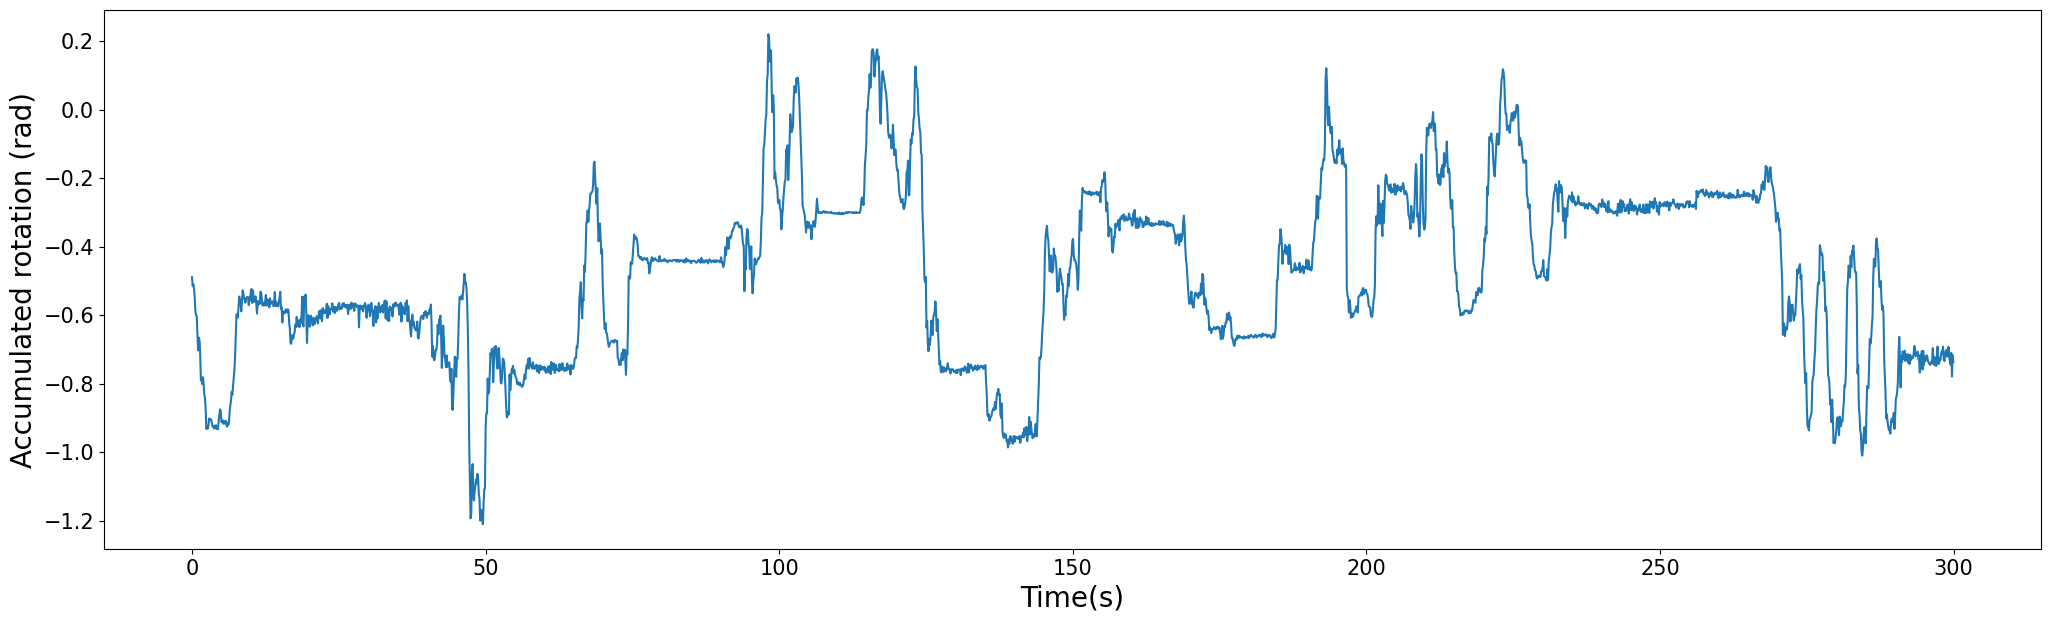

In [9]:
integrated_x_unwrapped =  fictrack_signal_decoding(integrated_x_no_series,time_array_imaging, 10, already_radian = True)
Forward_velocity = np.gradient(integrated_x_unwrapped)/volume_time
Forward_speed_radian = np.abs(Forward_velocity)
Forward_speed_degrees =Forward_speed_radian * 180/np.pi

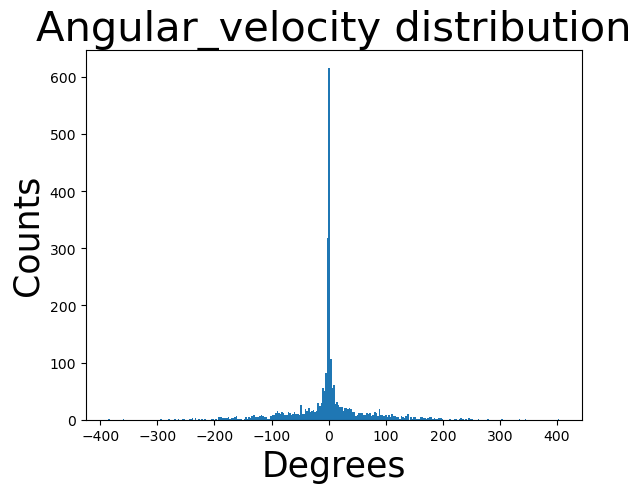

In [10]:
plt.hist(Angular_velocity_no_series*180/np.pi, bins ='auto')
plt.title('Angular_velocity distribution',fontsize = 30)
plt.xlabel('Degrees',fontsize = 25)
plt.ylabel('Counts',fontsize = 25)
plt.show()

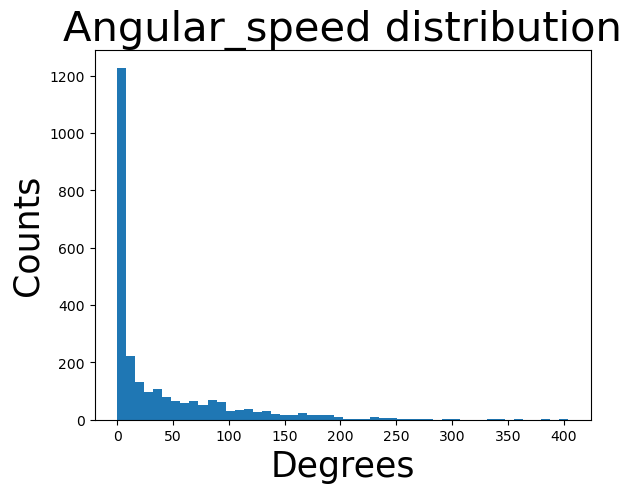

In [11]:
angular_speed_degrees = np.abs(Angular_velocity_no_series*180/np.pi)
plt.hist(angular_speed_degrees, bins ='auto')
plt.title('Angular_speed distribution',fontsize = 30)
plt.xlabel('Degrees',fontsize = 25)
plt.ylabel('Counts',fontsize = 25)
plt.show()

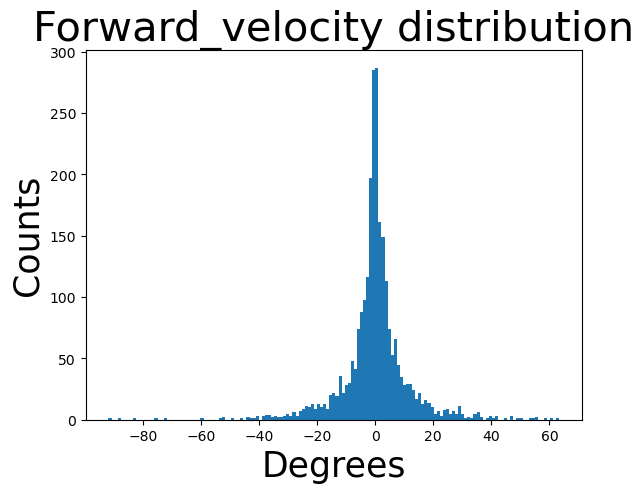

In [12]:
plt.hist(Forward_velocity *180/np.pi ,bins='auto')
plt.title('Forward_velocity distribution', fontsize = 30)
plt.xlabel('Degrees',fontsize = 25)
plt.ylabel('Counts',fontsize = 25)
plt.show()

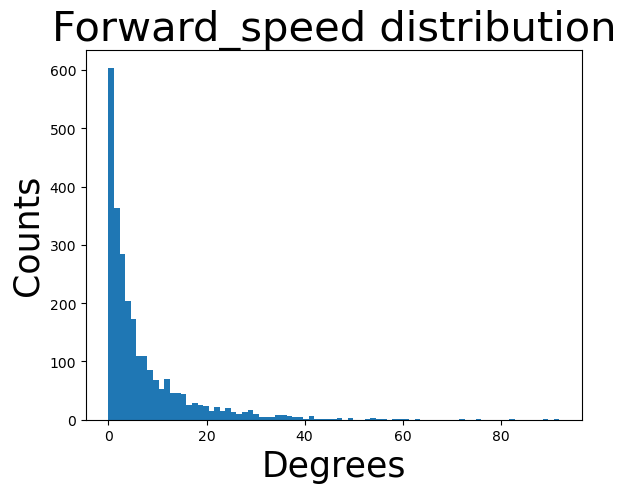

In [13]:
plt.hist(Forward_speed_degrees ,bins='auto')
plt.title('Forward_speed distribution',fontsize = 30)
plt.xlabel('Degrees',fontsize = 25)
plt.ylabel('Counts',fontsize = 25)
plt.show()

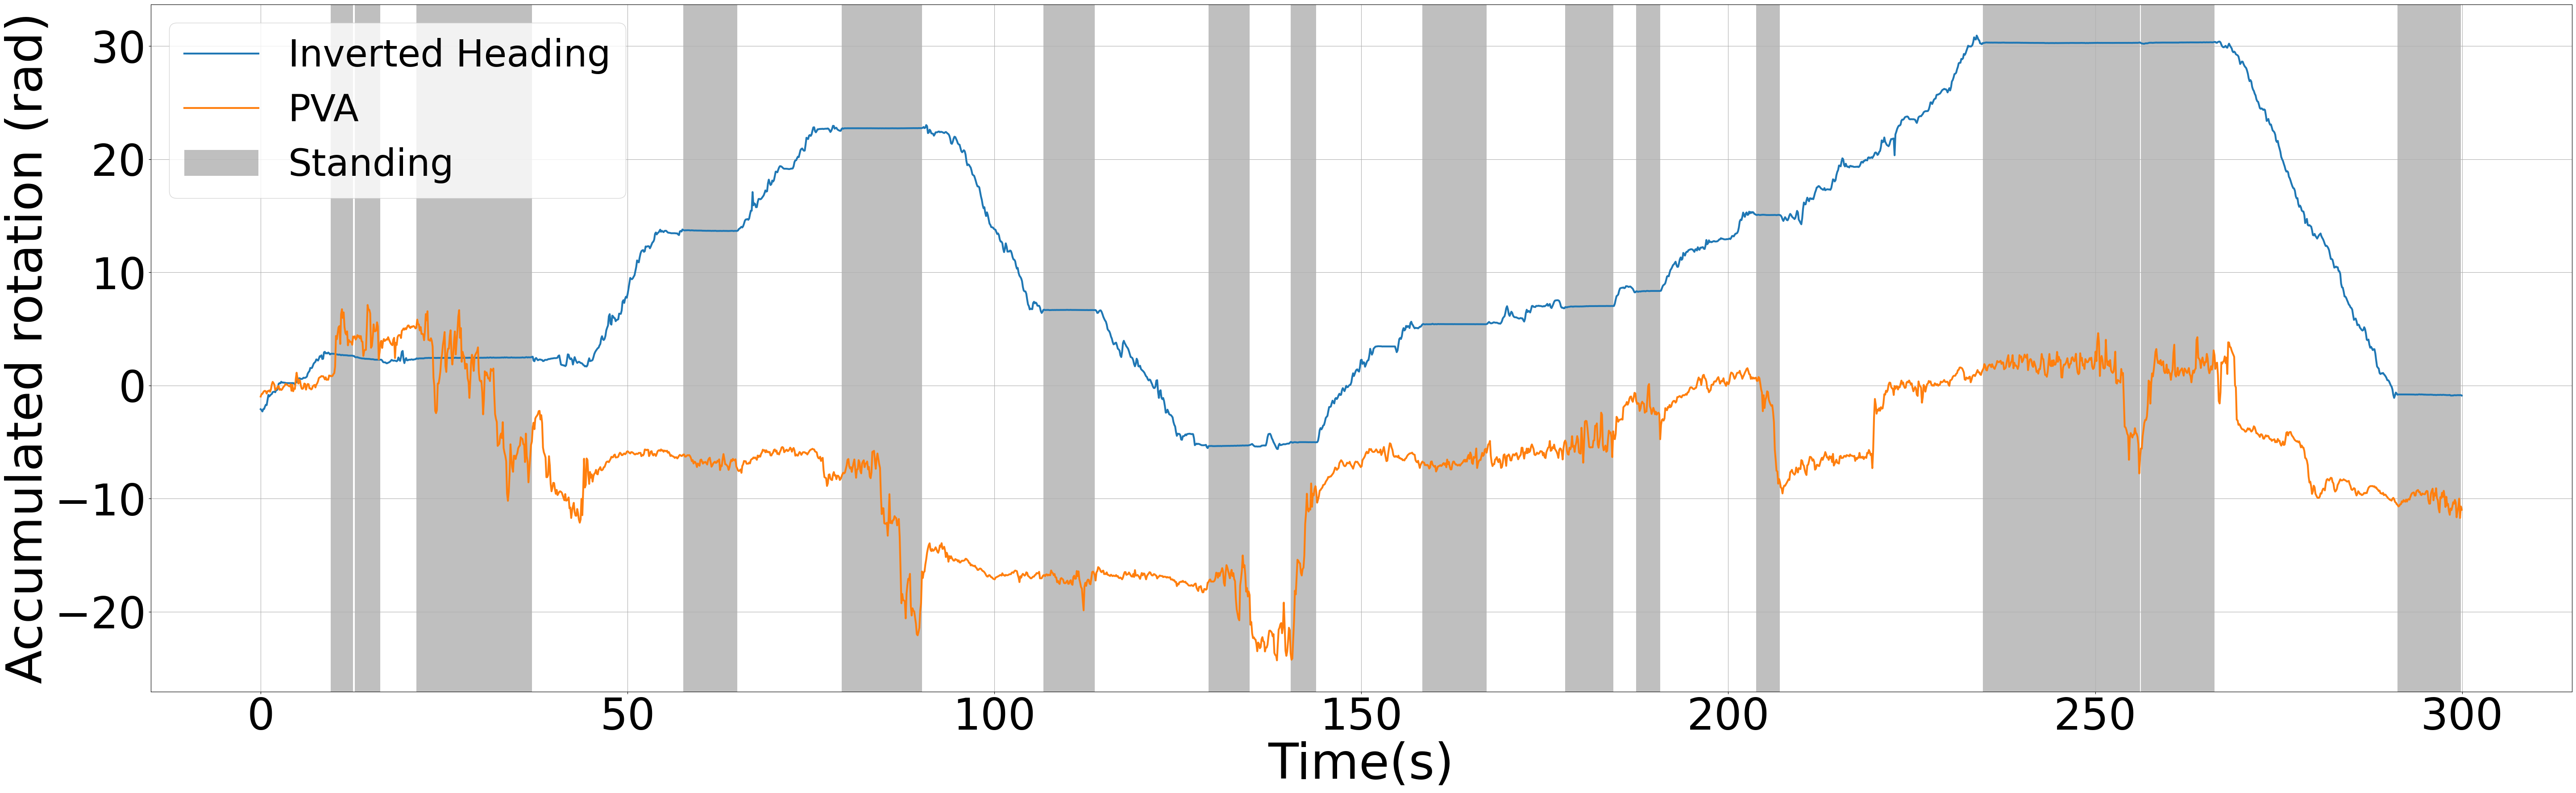

In [14]:
#find stop period and plot as shaded under wrapped PVA/behavior
persistence_stop_index_and_length = find_stop_period_on_heading(head_velocity_array = Angular_velocity,degree_of_tolerance =15,shortest_stopFrame=int(np.ceil(3/volume_time)))
plt.figure(figsize= (70,20))
plt.plot(time_array_imaging,Unwrapped_heading ,linewidth =3)
plt.plot(time_array_imaging, PVA_Unwrapped_Radian,linewidth =3)
#plt.plot(time_array_imaging, Forward_speed_radian,linewidth =3)
plt.xlabel('Time(s)', fontsize=80)
plt.ylabel('Accumulated rotation (rad)', fontsize=80)

#Plot calculated standing period under shaded area
for i in range(len(persistence_stop_index_and_length)):
    plt.axvspan((persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1])*volume_time, persistence_stop_index_and_length[i,0]*volume_time, color = 'grey', alpha = 0.5, lw =0,label = 'Standing')
if trial_type == 0:
    plt.legend(['Inverted Heading','PVA','Standing'],fontsize=60)
else:
    plt.legend(['Bar Position','PVA','Standing'],fontsize=60)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)
plt.grid()
plt.show()

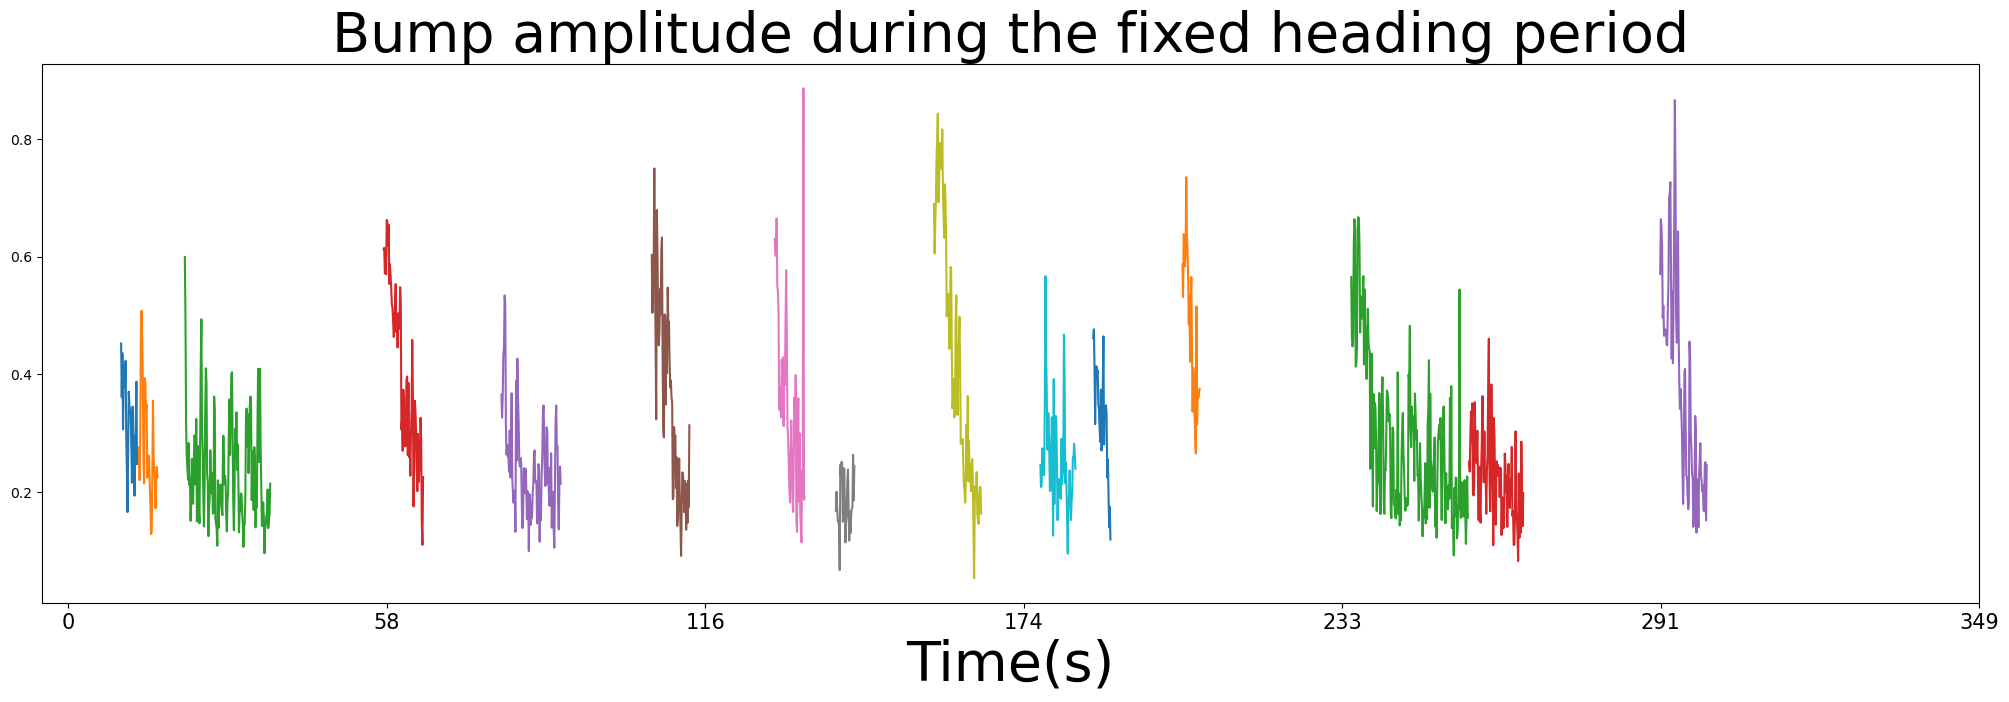

In [16]:
#Check bump amplitude during the time of fixed-heading period
plt.figure(figsize= (25,7))
for i in range(len(persistence_stop_index_and_length)):
    plt.plot(Bump_amplitude[persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1]+1:persistence_stop_index_and_length[i,0]+1])
plt.title('Bump amplitude during the fixed heading period', fontsize =40)
plt.xticks(ticks=plt.xticks()[0][1:], labels=np.array(plt.xticks()[0][1:]/volume_rate, dtype=np.int64), fontsize=15)
plt.xlabel('Time(s)', fontsize=40)
plt.show()

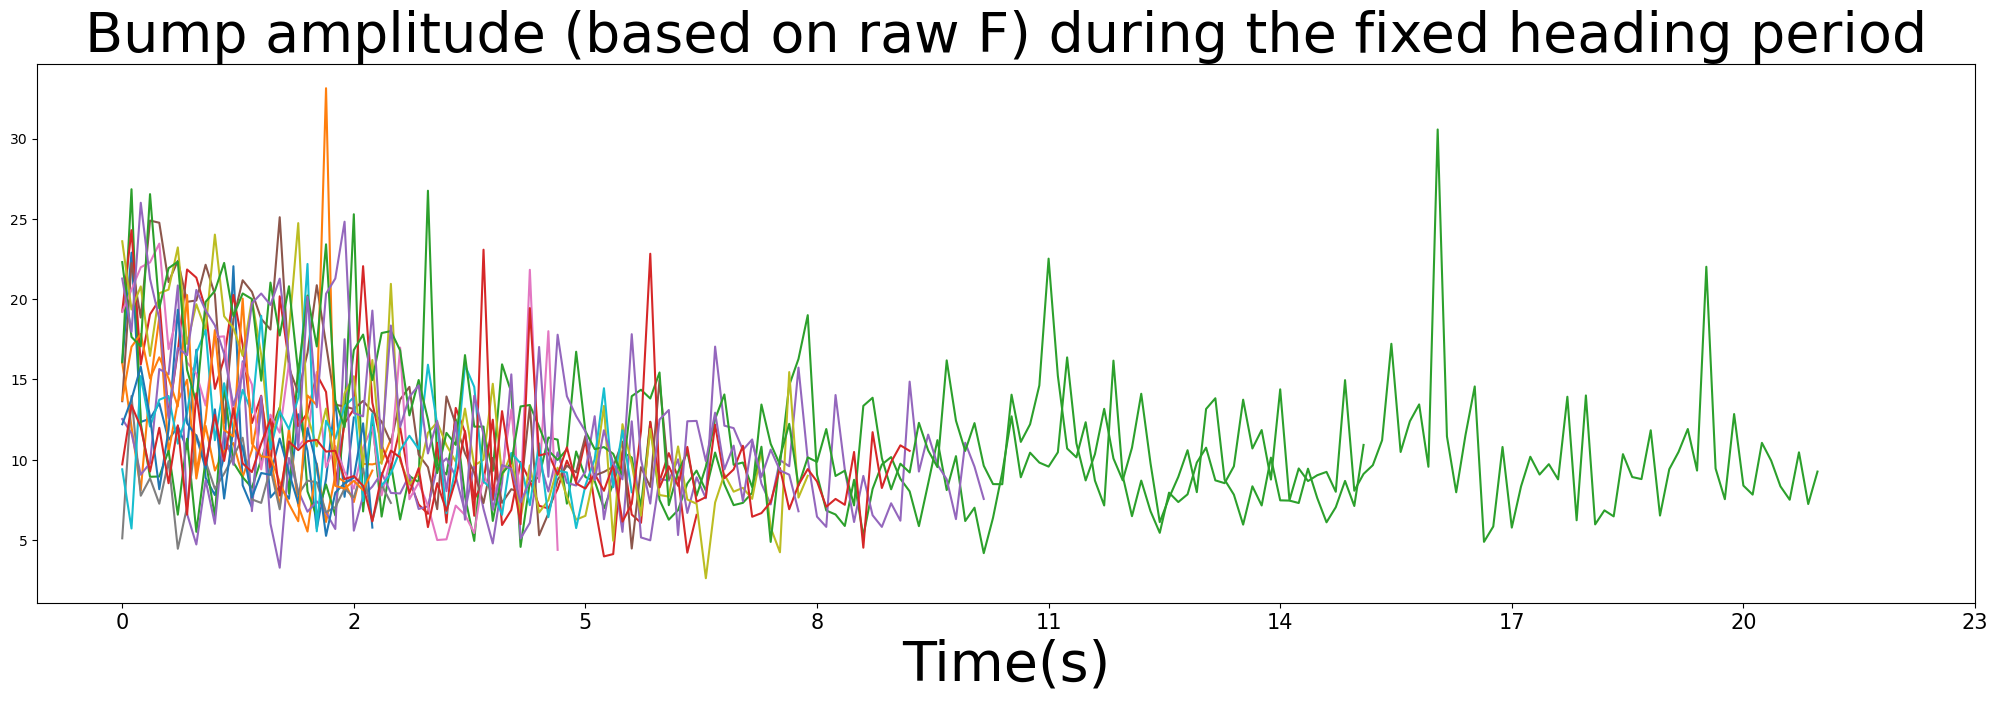

In [17]:
#Check bump amplitude (based on raw F) during the time of fixed-heading period
plt.figure(figsize= (25,7))
for i in range(len(persistence_stop_index_and_length)):
    plt.plot(bump_amplitude_F[persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1]+1:persistence_stop_index_and_length[i,0]+1])
plt.title('Bump amplitude (based on raw F) during the fixed heading period', fontsize =40)
plt.xticks(ticks=plt.xticks()[0][1:], labels=np.array(plt.xticks()[0][1:]/volume_rate, dtype=np.int64), fontsize=15)
plt.xlabel('Time(s)', fontsize=40)
plt.show()

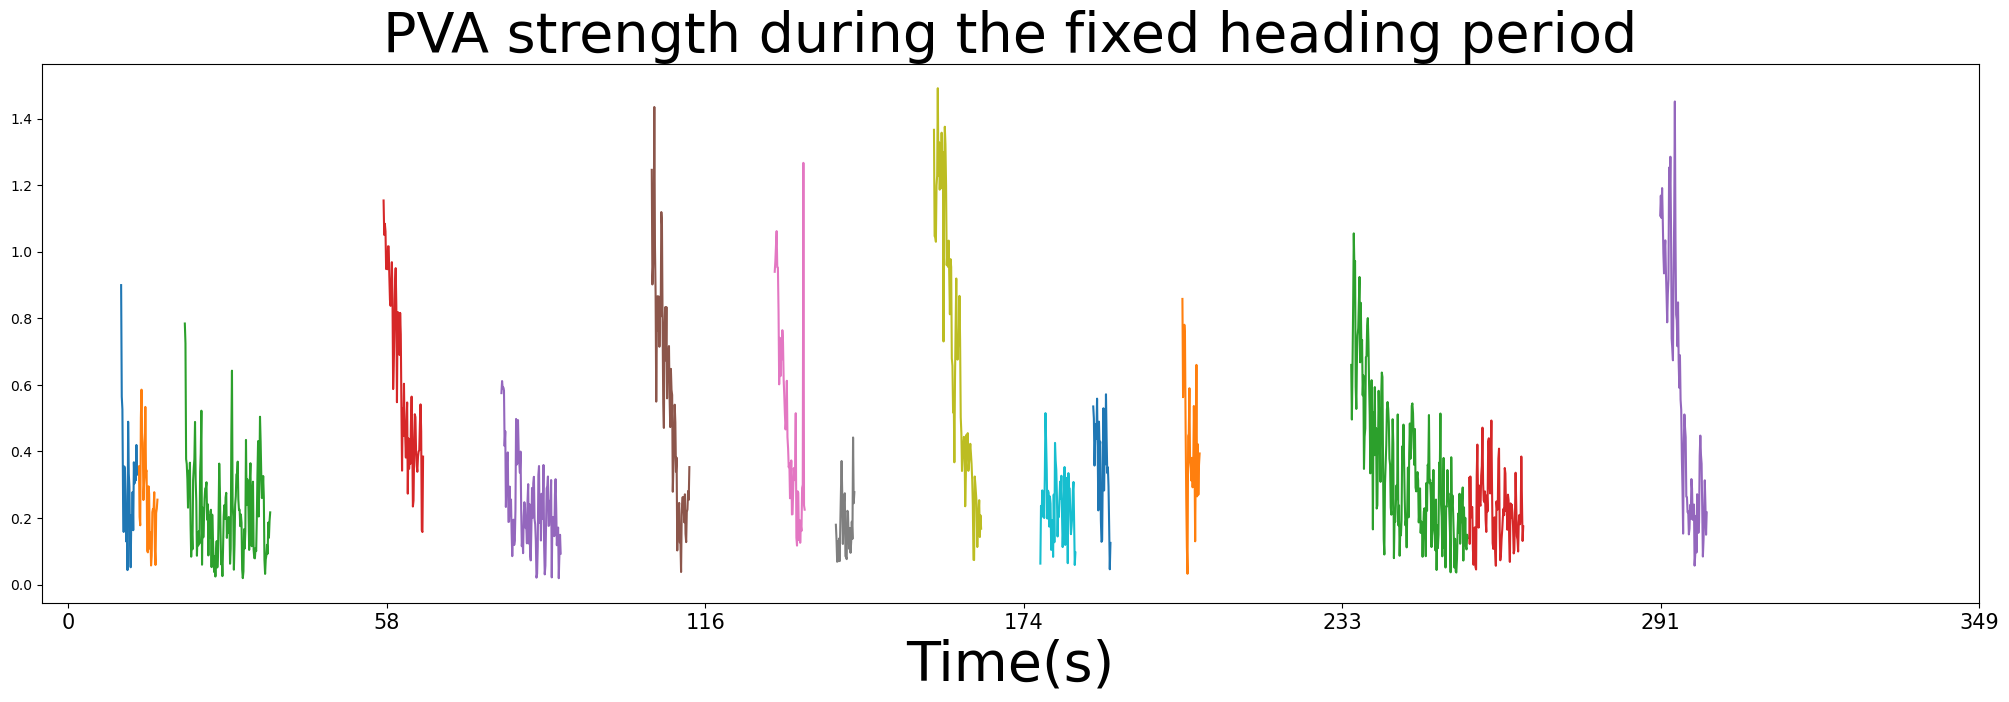

In [18]:
#Check PVA strength during the time of fixed-heading period
plt.figure(figsize= (25,7))
for i in range(len(persistence_stop_index_and_length)):
    plt.plot(PVA_strength[persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1]+1:persistence_stop_index_and_length[i,0]+1])
plt.xticks(ticks=plt.xticks()[0][1:], labels=np.array(plt.xticks()[0][1:]/volume_rate, dtype=np.int64), fontsize=15)
plt.title('PVA strength during the fixed heading period', fontsize =40)
plt.xlabel('Time(s)', fontsize=40)
plt.show()
    

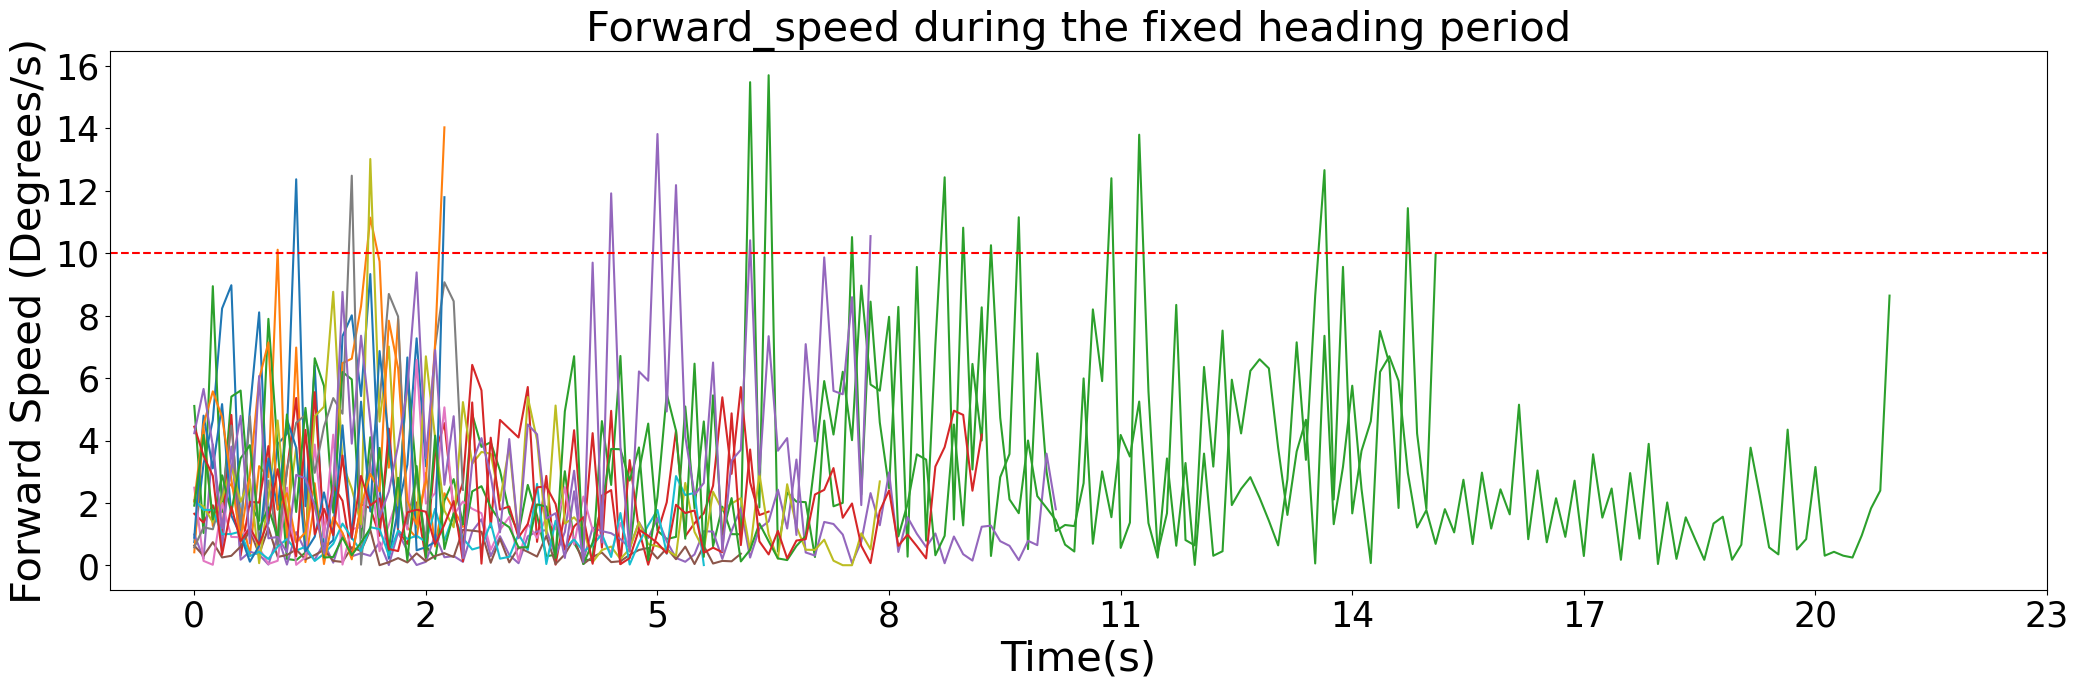

In [19]:
plt.figure(figsize= (25,7))
for i in range(len(persistence_stop_index_and_length)):
    plt.plot(Forward_speed_degrees[persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1]+1:persistence_stop_index_and_length[i,0]+1])
plt.xticks(ticks=plt.xticks()[0][1:], labels=np.array(plt.xticks()[0][1:]/volume_rate, dtype=np.int64), fontsize=25)
plt.title('Forward_speed during the fixed heading period', fontsize =30)
plt.axhline(y= 10, color = 'r',linestyle ='--')
plt.xlabel('Time(s)', fontsize=30)
plt.yticks(fontsize=25)
plt.ylabel('Forward Speed (Degrees/s)', fontsize=30)
plt.show()
    

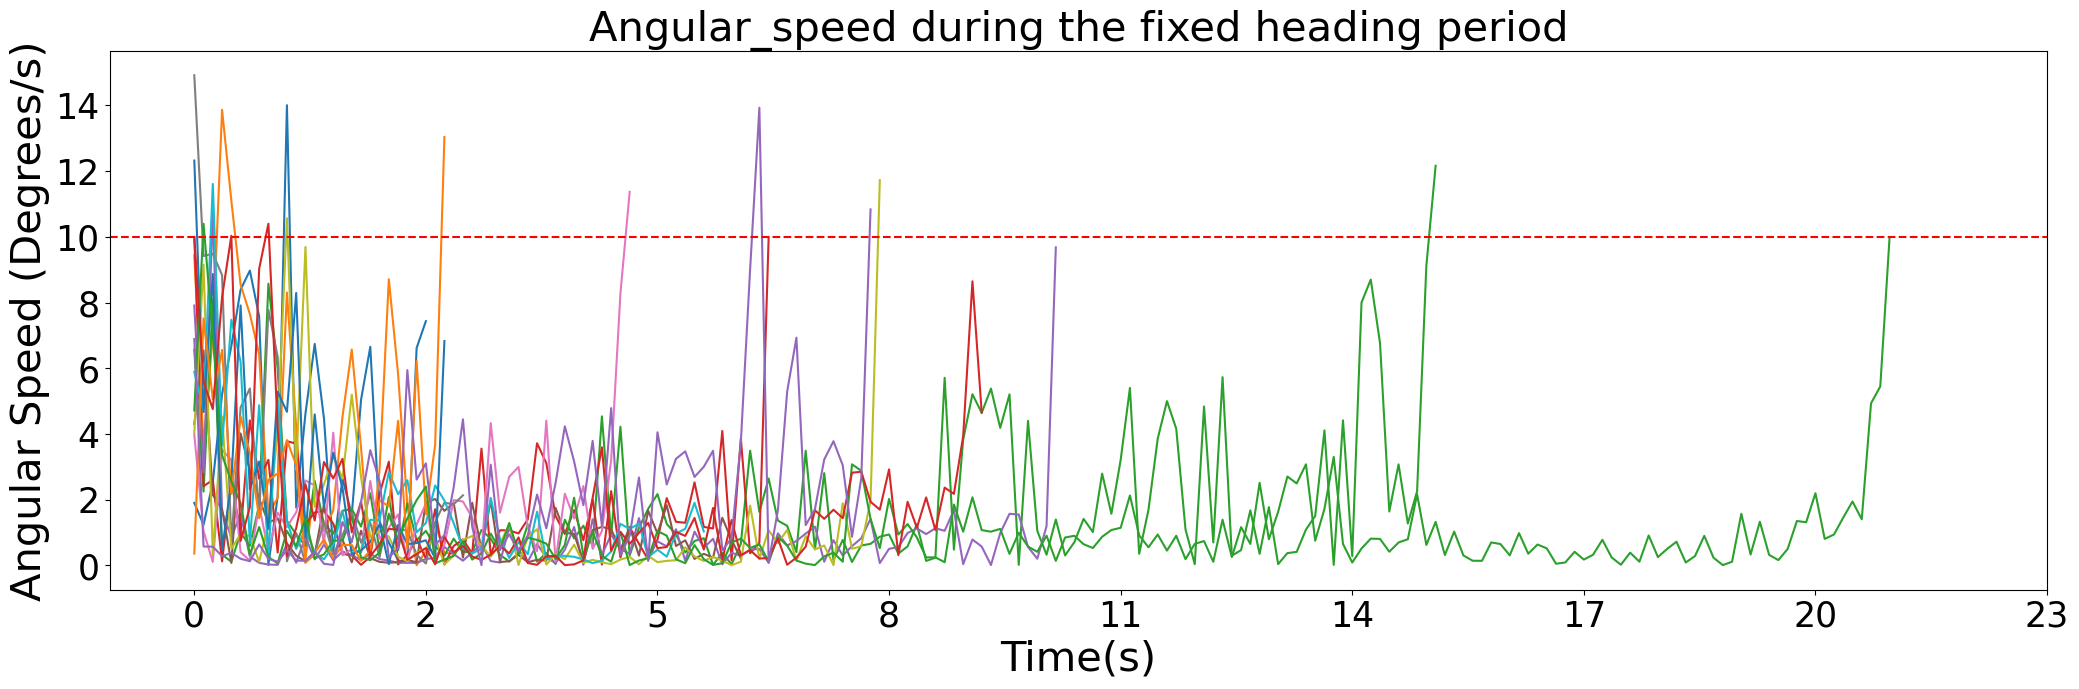

In [21]:
plt.figure(figsize= (25,7))
for i in range(len(persistence_stop_index_and_length)):
    plt.plot(angular_speed_degrees[persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1]+1:persistence_stop_index_and_length[i,0]+1])
plt.xticks(ticks=plt.xticks()[0][1:], labels=np.array(plt.xticks()[0][1:]/volume_rate, dtype=np.int64), fontsize=25)
plt.title('Angular_speed during the fixed heading period', fontsize =30)
plt.axhline(y= 10, color = 'r',linestyle ='--')
plt.xlabel('Time(s)', fontsize=30)
plt.yticks(fontsize=25)
plt.ylabel('Angular Speed (Degrees/s)', fontsize=30)
plt.show()
    

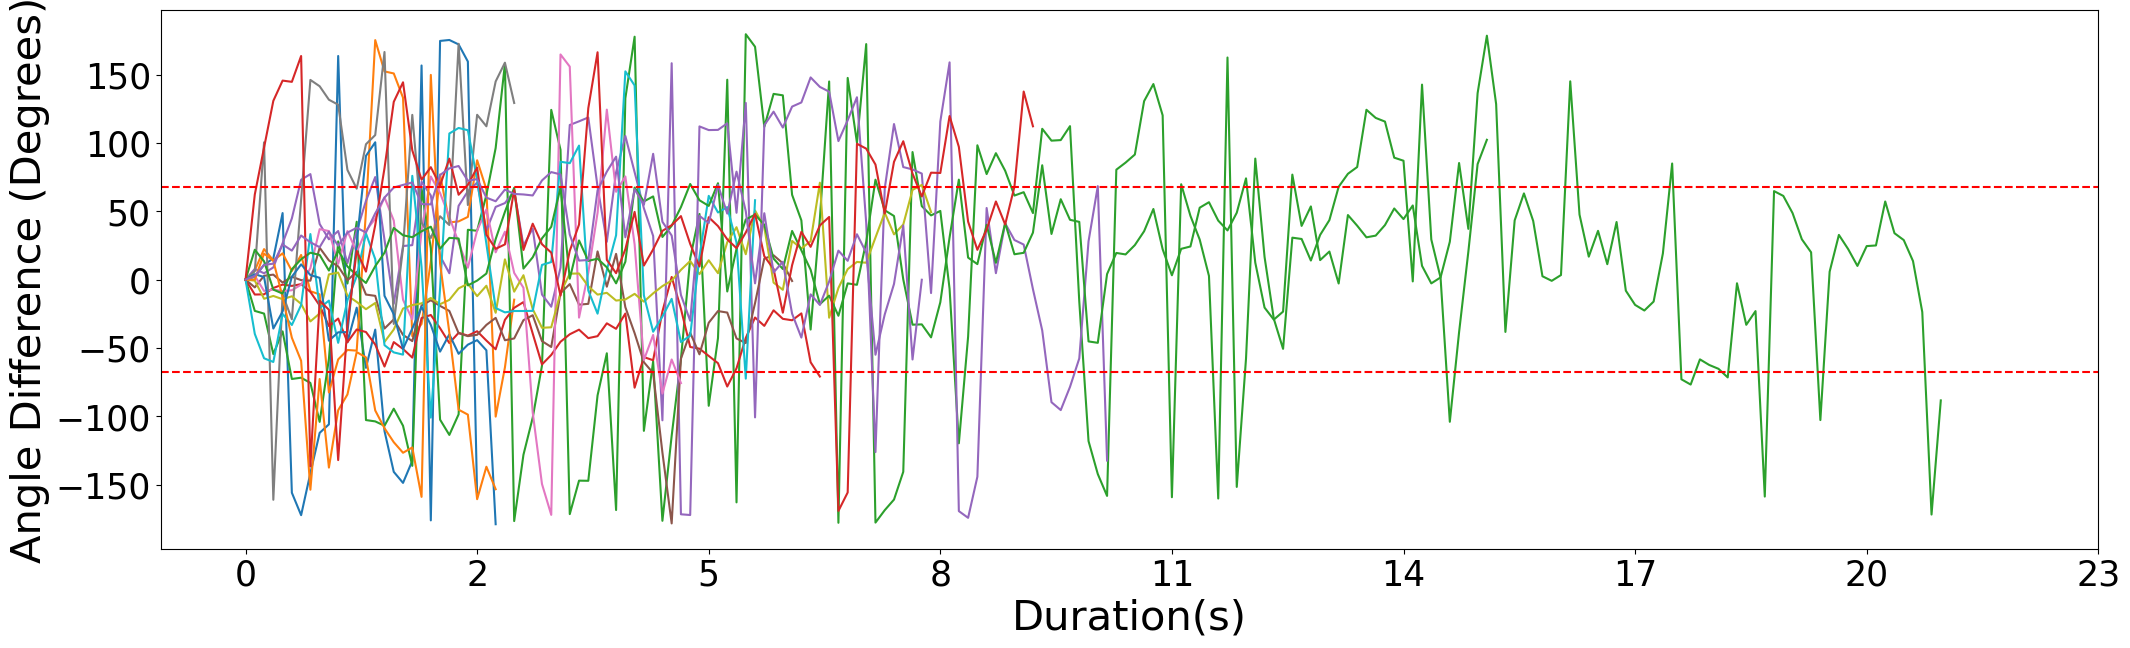

In [22]:
#Calculate annd plot difference throughout the stop period
difference_during_stop = []
current_difference_during_stop = []
current_forward_speed_during_stop = []
forward_speed_during_stop =[]
plt.figure(figsize= (25,7))
for current_index in range(len(persistence_stop_index_and_length)):
    current_stop_PVA = PVA_Angle_no_series[persistence_stop_index_and_length[current_index,0]-persistence_stop_index_and_length[current_index,1]+1]
    current_stop_start_index = persistence_stop_index_and_length[current_index,0]-persistence_stop_index_and_length[current_index,1]+1
    current_difference_during_stop = PVA_Angle_no_series[current_stop_start_index:persistence_stop_index_and_length[current_index,0]+1] - current_stop_PVA
    current_forward_speed_during_stop = Forward_speed_degrees[current_stop_start_index:persistence_stop_index_and_length[current_index,0]+1]
    #Modify the value so angle difference will never be different more than 180 degrees
    for j in range(len(current_difference_during_stop)):
        if np.abs(current_difference_during_stop[j]) > 180:
            if current_difference_during_stop[j] < 0:
                current_difference_during_stop[j] =  current_difference_during_stop[j] + 360
            else:
                current_difference_during_stop[j] =  current_difference_during_stop[j] - 360
    
    difference_during_stop.append(current_difference_during_stop)
    forward_speed_during_stop.append(current_forward_speed_during_stop)
    plt.plot(current_difference_during_stop)

max_length = 0
for i in range(len(difference_during_stop)):
    if max_length < len(difference_during_stop[i]):
        max_length = len(difference_during_stop[i])

time_array_PVA_difference_stop = np.arange(max_length)/volume_rate
plt.axhline(y= 67.5, color = 'r',linestyle ='--')
plt.axhline(y= -67.5, color = 'r',linestyle ='--')
plt.ylabel('Angle Difference (Degrees)', fontsize=30)
plt.xlabel('Duration(s)',fontsize =30)
plt.xticks(ticks=plt.xticks()[0][1:], labels=np.array(plt.xticks()[0][1:]/volume_rate, dtype=np.int64), fontsize=25)
plt.yticks(fontsize=25)
plt.show()
    

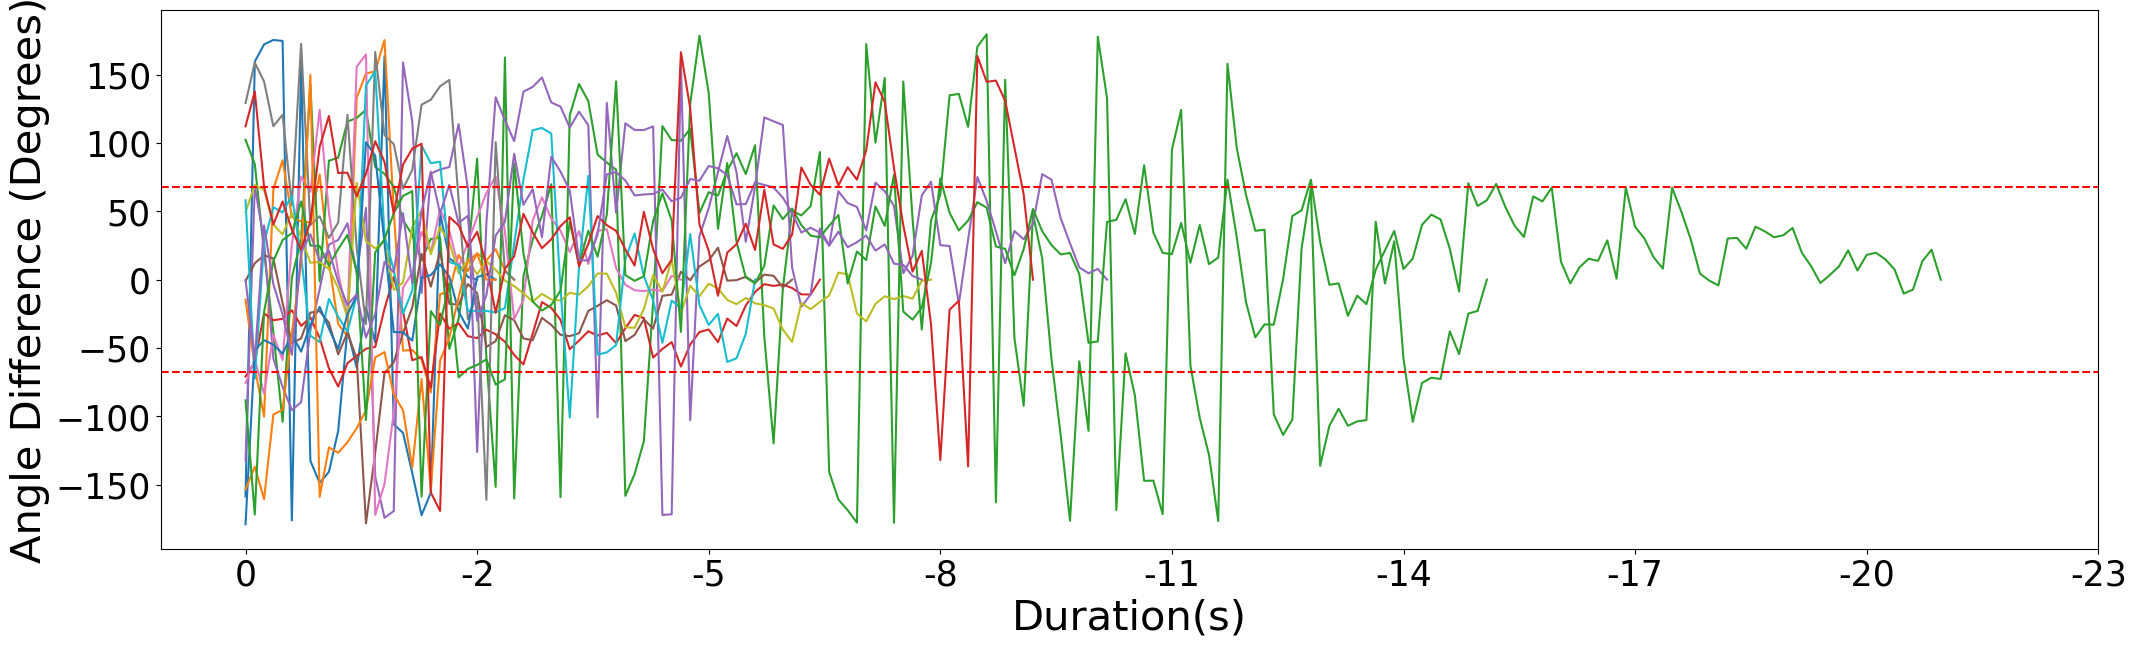

In [24]:
#Plot the reverse of difference during fixed heading period (align at the restart)
plt.figure(figsize= (25,7))
for i in range(len(difference_during_stop)):
    plt.plot(np.flip(difference_during_stop[i]))
             
max_length = 0
for i in range(len(difference_during_stop)):
    if max_length < len(difference_during_stop[i]):
        max_length = len(difference_during_stop[i])

time_array_PVA_difference_stop = np.arange(max_length)/volume_rate
plt.axhline(y= 67.5, color = 'r',linestyle ='--')
plt.axhline(y= -67.5, color = 'r',linestyle ='--')
plt.ylabel('Angle Difference (Degrees)', fontsize=30)
plt.xlabel('Duration(s)',fontsize =30)
plt.xticks(ticks=plt.xticks()[0][1:], labels=np.array(plt.xticks()[0][1:]/-volume_rate, dtype=np.int64), fontsize=25)
plt.yticks(fontsize=25)
plt.show()

In [25]:
PVA_angle_at_stop = PVA_during_stopPeriod(stop_index_array = persistence_stop_index_and_length, PVA_array =PVA_Angle_no_series, volume_time=volume_time)
PVA_angle_at_stop.insert(0,'FlyTrial','TQfly058-007')
PVA_angle_at_stop.insert(1,'Genotype','VT020739>GCaMP7f')
PVA_angle_at_stop.insert(2,'TrialType','dark')
PVA_angle_at_stop

FlyTrial          Genotype TrialType  Period_duration   
0   TQfly058-007  VT020739>GCaMP7f      dark          3.03108  \
1   TQfly058-007  VT020739>GCaMP7f      dark          3.49740   
2   TQfly058-007  VT020739>GCaMP7f      dark         15.73830   
3   TQfly058-007  VT020739>GCaMP7f      dark          7.34454   
4   TQfly058-007  VT020739>GCaMP7f      dark         10.95852   
5   TQfly058-007  VT020739>GCaMP7f      dark          6.99480   
6   TQfly058-007  VT020739>GCaMP7f      dark          5.59584   
7   TQfly058-007  VT020739>GCaMP7f      dark          3.49740   
8   TQfly058-007  VT020739>GCaMP7f      dark          8.74350   
9   TQfly058-007  VT020739>GCaMP7f      dark          6.52848   
10  TQfly058-007  VT020739>GCaMP7f      dark          3.26424   
11  TQfly058-007  VT020739>GCaMP7f      dark          3.26424   
12  TQfly058-007  VT020739>GCaMP7f      dark         21.45072   
13  TQfly058-007  VT020739>GCaMP7f      dark         10.02588   
14  TQfly058-007  VT020739>GCaMP7f      dark          8.62692   

    PVA_before_stop  PVA_at_restart  PVA_100ms_before_restart   
0         46.224389     -112.451816               -154.194184  \
1       -128.068081     -142.723037                167.689465   
2        -26.883813       75.445973                 57.666606   
3         10.250024      -60.653949                -50.195587   
4        -90.093839      137.532157                -21.700657   
5        119.312114      118.310753                131.300665   
6         94.471753       18.769381                 36.046918   
7         50.801992     -179.927103               -150.450858   
8        -30.379687       19.016891                 38.920792   
9         69.442993      127.534938                 -2.998983   
10       -93.692757       87.339911               -145.413340   
11        22.986872     -130.342621               -113.919462   
12        85.924270       -2.433146                -85.959096   
13        39.782555      151.989529                177.436932   
14       107.014640      106.940845                 48.590560   

    PVA_500ms_before_restart  PVA_in_middle  PVA_2s_before_restart   
0                -139.095456      25.733063             -65.891010  \
1                 -40.702866      47.220414             179.985933   
2                -130.903765     145.478815              16.676606   
3                 -18.428211     -29.205445             -13.060096   
4                -168.561655      68.264690              68.892421   
5                 102.115657      76.272984              80.151988   
6                  35.675866     121.669651              88.529434   
7                 171.434432     156.588467             117.377311   
8                   2.766299     -35.237404             -32.542556   
9                 118.582903      48.671153              44.553664   
10               -147.948530      -3.107116            -132.229266   
11                -72.150553     -33.892384             -72.565250   
12                114.884384      40.714770             147.184705   
13                 96.979849      89.370969             124.000380   
14                 81.542401     120.952358             155.612440   

    PVA_3s_after_stop  PVA_5s_after_stop  PVA_10s_after_stop  
0         -112.451816                NaN                 NaN  
1          -40.702866                NaN                 NaN  
2            8.879191         150.875326           21.837192  
3          -27.507175         -68.819260                 NaN  
4          -19.134719         -11.481708          -97.098335  
5           78.947411          80.151988                 NaN  
6          130.360450         120.222198                 NaN  
7          171.434432                NaN                 NaN  
8          -42.469016         -40.779638                 NaN  
9          142.806914        -148.467240                 NaN  
10        -137.968062                NaN                 NaN  
11        -137.669655                NaN         

In [26]:
Forward_speed_at_stop = forwrad_speed_during_stopPeriod(stop_index_array=persistence_stop_index_and_length,forward_speed_array=Forward_speed_degrees, volume_time=volume_time)
Forward_speed_at_stop

forward_speed_before_stop  forward_speed_at_restart   
0                    0.751624                  3.183531  \
1                    0.421721                  1.242691   
2                    5.107702                  9.964384   
3                    1.655658                  1.724330   
4                    0.992143                  1.800281   
5                    0.636875                  0.375692   
6                    2.491102                  0.518567   
7                    0.580021                  2.421522   
8                    2.045621                  2.691070   
9                    2.093551                  0.012699   
10                   0.890169                 11.793007   
11                   2.056665                 14.030124   
12                   1.915715                  8.641603   
13                   4.444328                  4.189851   
14                   4.235858                 10.547108   

    forward_speed_100ms_before_restart  forward_speed_500ms_before_restart   
0                             7.274251                            0.217746  \
1                             1.798774                            2.960588   
2                             1.810485                            1.841025   
3                             1.614100                            2.933666   
4                             3.580378                            0.171369   
5                             0.132637                            0.628943   
6                             1.359882                            1.142951   
7                             8.461564                            0.677631   
8                             0.519528                            0.008676   
9                             2.323455                            0.378188   
10                            0.753513                            6.661443   
11                            7.118999                            2.080676   
12                            2.397992                            0.254060   
13                            2.394199                            3.789244   
14                            1.933206                            5.590905   

    forward_speed_in_middle  forward_speed_2s_before_restart   
0                  1.897491                         1.337729  \
1                  0.189391                         0.108058   
2                  0.271611                         0.643226   
3                  5.606420                         4.952210   
4                  0.845909                         0.432179   
5                  1.143135                         0.046540   
6                  1.151260                         1.814796   
7                  4.443985                         4.824224   
8                  4.013073                         1.766776   
9                  0.794251                         0.046568   
10                 0.920222                         4.685437   
11                 2.633227                         2.312528   
12                 2.221377                         0.182639   
13                 1.547019                         2.421224   
14                 4.516969                         6.499170   

    forward_speed_3s_after_stop  forward_speed_5s_after_stop   
0                      3.183531                          NaN  \
1                      2.960588                          NaN   
2                      0.641606                     0.196397   
3                      0.211785                     0.737695   
4                      0.117179                     0.168418   
5                      0.134782                     0.046540   
6                      1.981185                     2.206934   
7                      0.677631                          NaN   
8                      6.697881                     1.183759   
9                      0.760459                     0.451955   
10                     0.585402                          NaN   
11               

In [27]:
Bump_amplitude_at_stop = bump_amplitude_during_stopPeriod(stop_index_array=persistence_stop_index_and_length,bump_amplitude_array=Bump_amplitude_no_series, volume_time=volume_time)
Bump_amplitude_at_stop

bump_amplitude_before_stop  bump_amplitude_at_restart   
0                     0.452310                   0.247497  \
1                     0.276012                   0.224819   
2                     0.599366                   0.214008   
3                     0.612753                   0.225322   
4                     0.365321                   0.213935   
5                     0.602702                   0.313368   
6                     0.630075                   0.191234   
7                     0.167494                   0.244267   
8                     0.689268                   0.163016   
9                     0.246044                   0.239249   
10                    0.461598                   0.119064   
11                    0.586570                   0.375116   
12                    0.565387                   0.156223   
13                    0.251456                   0.198026   
14                    0.570325                   0.245681   

    bump_amplitude_100ms_before_restart  bump_amplitude_500ms_before_restart   
0                              0.387393                             0.193588  \
1                              0.242374                             0.219115   
2                              0.159773                             0.204294   
3                              0.110147                             0.326021   
4                              0.242918                             0.181207   
5                              0.173836                             0.213322   
6                              0.186669                             0.236761   
7                              0.185824                             0.171823   
8                              0.208568                             0.145743   
9                              0.265397                             0.258711   
10                             0.174671                             0.255086   
11                             0.368048                             0.314650   
12                             0.226333                             0.161448   
13                             0.141699                             0.130322   
14                             0.151261                             0.166833   

    bump_amplitude_in_middle  bump_amplitude_2s_before_restart   
0                   0.370386                          0.294843  \
1                   0.237872                          0.348605   
2                   0.186802                          0.356837   
3                   0.373764                          0.458387   
4                   0.144017                          0.241090   
5                   0.377500                          0.192817   
6                   0.206250                          0.270912   
7                   0.185315                          0.157963   
8                   0.330671                          0.246122   
9                   0.152113                          0.396238   
10                  0.270351                          0.306612   
11                  0.526424                          0.484506   
12                  0.389292                          0.121022   
13                  0.144024                          0.159151   
14                  0.179574                          0.305303   

    bump_amplitude_3s_after_stop  bump_amplitude_5s_after_stop   
0                       0.247497                           NaN  \
1                       0.219115                           NaN   
2                       0.418133                      0.197974   
3                       0.477301                      0.227577   
4                       0.426602                      0.195013   
5                       0.547376                      0.192817   
6                       0.260600                      0.114324   
7                       0.171823                           NaN   
8                       0.471087                      0.281935   
9                       0.320

In [28]:
output_df = pd.concat([PVA_angle_at_stop,Forward_speed_at_stop,Bump_amplitude_at_stop], axis=1)
output_df

FlyTrial          Genotype TrialType  Period_duration   
0   TQfly058-007  VT020739>GCaMP7f      dark          3.03108  \
1   TQfly058-007  VT020739>GCaMP7f      dark          3.49740   
2   TQfly058-007  VT020739>GCaMP7f      dark         15.73830   
3   TQfly058-007  VT020739>GCaMP7f      dark          7.34454   
4   TQfly058-007  VT020739>GCaMP7f      dark         10.95852   
5   TQfly058-007  VT020739>GCaMP7f      dark          6.99480   
6   TQfly058-007  VT020739>GCaMP7f      dark          5.59584   
7   TQfly058-007  VT020739>GCaMP7f      dark          3.49740   
8   TQfly058-007  VT020739>GCaMP7f      dark          8.74350   
9   TQfly058-007  VT020739>GCaMP7f      dark          6.52848   
10  TQfly058-007  VT020739>GCaMP7f      dark          3.26424   
11  TQfly058-007  VT020739>GCaMP7f      dark          3.26424   
12  TQfly058-007  VT020739>GCaMP7f      dark         21.45072   
13  TQfly058-007  VT020739>GCaMP7f      dark         10.02588   
14  TQfly058-007  VT020739>GCaMP7f      dark          8.62692   

    PVA_before_stop  PVA_at_restart  PVA_100ms_before_restart   
0         46.224389     -112.451816               -154.194184  \
1       -128.068081     -142.723037                167.689465   
2        -26.883813       75.445973                 57.666606   
3         10.250024      -60.653949                -50.195587   
4        -90.093839      137.532157                -21.700657   
5        119.312114      118.310753                131.300665   
6         94.471753       18.769381                 36.046918   
7         50.801992     -179.927103               -150.450858   
8        -30.379687       19.016891                 38.920792   
9         69.442993      127.534938                 -2.998983   
10       -93.692757       87.339911               -145.413340   
11        22.986872     -130.342621               -113.919462   
12        85.924270       -2.433146                -85.959096   
13        39.782555      151.989529                177.436932   
14       107.014640      106.940845                 48.590560   

    PVA_500ms_before_restart  PVA_in_middle  PVA_2s_before_restart  ...   
0                -139.095456      25.733063             -65.891010  ...  \
1                 -40.702866      47.220414             179.985933  ...   
2                -130.903765     145.478815              16.676606  ...   
3                 -18.428211     -29.205445             -13.060096  ...   
4                -168.561655      68.264690              68.892421  ...   
5                 102.115657      76.272984              80.151988  ...   
6                  35.675866     121.669651              88.529434  ...   
7                 171.434432     156.588467             117.377311  ...   
8                   2.766299     -35.237404             -32.542556  ...   
9                 118.582903      48.671153              44.553664  ...   
10               -147.948530      -3.107116            -132.229266  ...   
11                -72.150553     -33.892384             -72.565250  ...   
12                114.884384      40.714770             147.184705  ...   
13                 96.979849      89.370969             124.000380  ...   
14                 81.542401     120.952358             155.612440  ...   

    forward_speed_10s_after_stop  bump_amplitude_before_stop   
0                            NaN                    0.452310  \
1                            NaN                    0.276012   
2                       8.266575                    0.599366   
3                            NaN                    0.612753   
4                       1.240284                    0.365321   
5                            NaN                    0.602702   
6                            NaN                    0.630075   
7                            NaN                    0.167494   
8                            NaN                    0.689268   
9                            NaN                    0.246044   
10                   

In [29]:
output_df.to_csv('/home/tianhaoqiu/Documents/GitHub/2p_analysis/fixed_heading_period_data/points_during_stop_period/dark trial/PENb_EB/TQfly058-007-Fixed_Heading_Period.csv',encoding = 'utf-8', index=False)

In [48]:
#Combine all persistence files for pooled analysis and statistics 

pooled_directory = ('/home/tianhaoqiu/Documents/GitHub/2p_analysis/fixed_heading_period_data/points_during_stop_period/cl trial/EPG_PB')
pooled_file_list = []
count = 0
for single_df in os.listdir(pooled_directory):
    if count == 0:
        persistence_data_pooled = pd.read_csv(sep.join([pooled_directory, single_df]))
        count = count + 1
    else:
        current_df = pd.read_csv(sep.join([pooled_directory, single_df]))
        persistence_data_pooled = pd.concat([persistence_data_pooled,current_df], ignore_index=True)
        count = count + 1

persistence_data_pooled
        

FlyTrial        Genotype TrialType  Period_duration  PVA_before_stop   
0    TQfly020-004  R60D05>GCaMP7f        cl          8.63612       152.779284  \
1    TQfly020-004  R60D05>GCaMP7f        cl          4.31806       -86.439229   
2    TQfly020-004  R60D05>GCaMP7f        cl         37.35624       -85.523872   
3    TQfly020-004  R60D05>GCaMP7f        cl          5.92478        -1.320021   
4    TQfly020-004  R60D05>GCaMP7f        cl          6.92898       104.161500   
..            ...             ...       ...              ...              ...   
144  TQfly006-004  R60D05>GCaMP7f        cl         20.02497       -42.736785   
145  TQfly006-004  R60D05>GCaMP7f        cl         23.74218       138.222288   
146  TQfly006-004  R60D05>GCaMP7f        cl         15.58830      -142.700005   
147  TQfly006-004  R60D05>GCaMP7f        cl         13.07019      -131.178308   
148  TQfly006-004  R60D05>GCaMP7f        cl         88.01394       149.353316   

     PVA_at_restart  PVA_100ms_before_restart  PVA_500ms_before_restart   
0        129.954677                156.596466                 16.232703  \
1        -68.797495                -74.962955                -69.155067   
2        -64.215069                -65.600353                -34.962486   
3         32.400089                 40.185377                 39.926749   
4        103.727001                105.218979                104.758681   
..              ...                       ...                       ...   
144      -77.586427                -48.538572                -72.358036   
145     -163.702983               -173.821122               -166.495025   
146     -149.362476               -157.569945                -99.942970   
147     -150.006876               -143.112831                177.899859   
148     -118.466666                 55.608811                 50.969139   

     PVA_in_middle  PVA_2s_before_restart  ...  forward_speed_10s_after_stop   
0      -157.673166             113.858629  ...                           NaN  \
1       -55.013859             -65.503918  ...                           NaN   
2       -24.163843             -84.568892  ...                      2.245938   
3        43.955119              66.408276  ...                           NaN   
4        96.081117              99.294985  ...                           NaN   
..             ...                    ...  ...                           ...   
144    -132.141746            -100.250723  ...                      0.946913   
145    -165.264493             142.279049  ...                      5.568344   
146    -120.791635             162.518259  ...                      0.521308   
147    -127.937979            -165.489649  ...                     11.361901   
148      19.296692              47.018918  ...                      0.310718   

     bump_amplitude_before_stop  bump_amplitude_at_restart   
0                      0.145043                   0.120168  \
1                      0.755526                   0.494114   
2                      0.567810                   0.124029   
3                      0.446624                   0.502485   
4                      1.447311                   0.958967   
..                          ...                        ...   
144                    0.462485                   0.254206   
145                    0.691765                   0.238209   
146                    0.382103                   0.301008   
147                    0.344727                   0.240625   
148                    0.219292                   0.105966   

     bump_amplitude_100ms_before_restart  bump_amplitude_500ms_before_restart   
0                               0.118655                             0.180550  \
1                               0.514409                             0.639346   
2                               0.107755                             0.185554   
3                               0.438824                             0.672808   
4                       

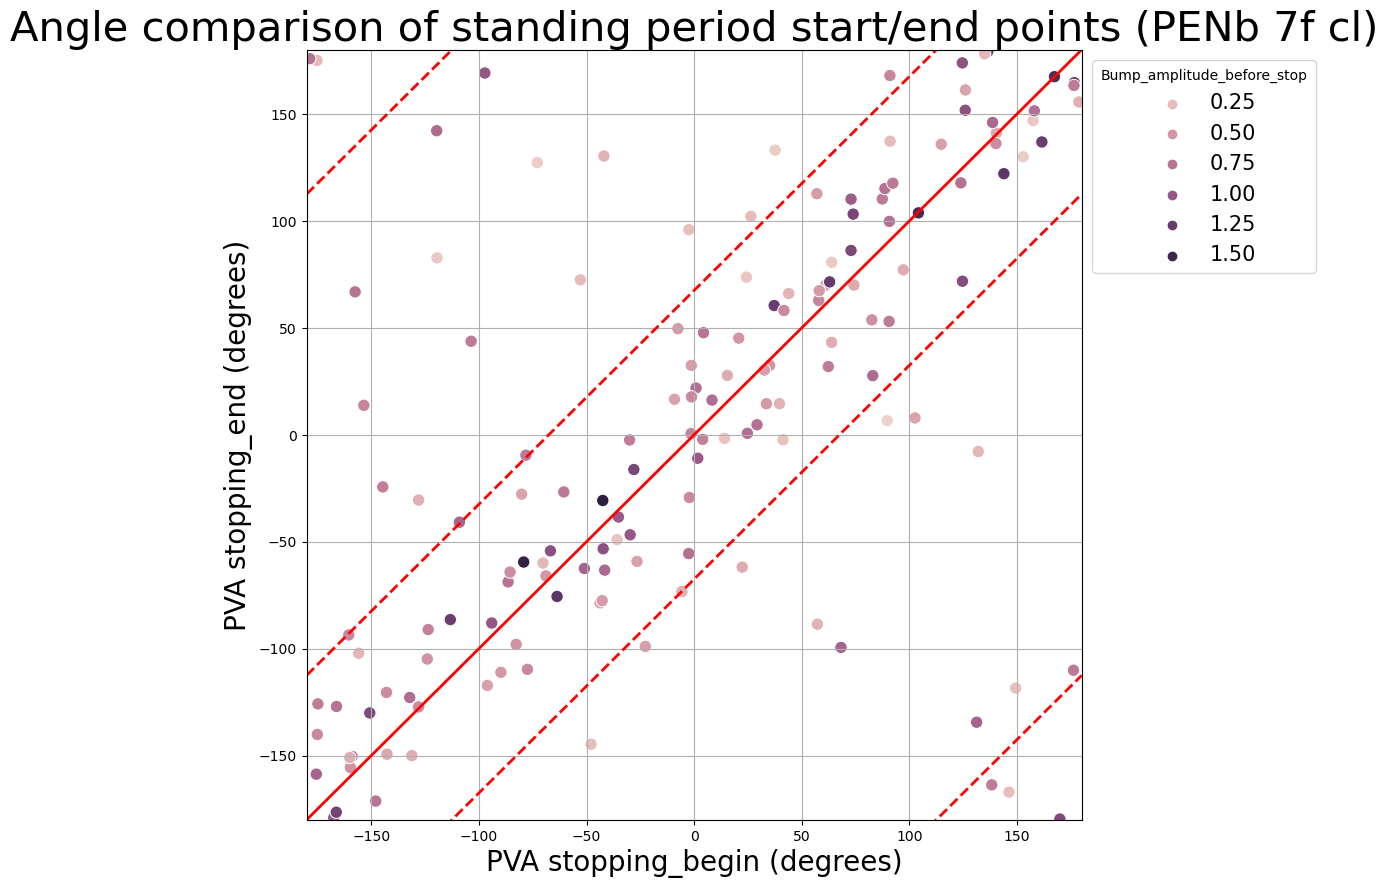

In [49]:
plt.figure(figsize= (10,10))
cmap = sns.cubehelix_palette(rot = -.2, as_cmap = True)
snsplot = sns.scatterplot(data = persistence_data_pooled, x='PVA_before_stop', y='PVA_at_restart', hue = 'bump_amplitude_before_stop',s =80)
snsplot.legend(bbox_to_anchor= (1,1), title = 'Bump_amplitude_before_stop', fontsize = 15)
X_plot = np.linspace(-180, 180, 100)
Y_plot = X_plot
plt.plot(X_plot,Y_plot, color='r', linewidth =2)
plt.plot(X_plot,Y_plot + 67.5, color='r', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot - 67.5, color='r', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot + 292.5, color= 'r', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot - 292.5, color='r', linestyle ='--', linewidth =2)
plt.ylim(-180, 180)
plt.xlim(-180, 180)
plt.title('Angle comparison of standing period start/end points (PENb 7f cl)', fontsize =30)
plt.ylabel('PVA stopping_end (degrees)',fontsize= 20)
plt.xlabel('PVA stopping_begin (degrees)',fontsize= 20)
#plt.setp(snsplot.get_legend().get_texts(), fontsize = 10)
plt.grid()
plt.show()

In [50]:
## Pilot code for boot stramping paired angle difference between start and end of the stopping period

#initialize a bootstrap array
bootstrap_mean_angle_differences_10000 = np.zeros(50000)
#size of each sampling 
pair_num = len(persistence_data_pooled['PVA_before_stop'])

for i in range(len(bootstrap_mean_angle_differences_10000)):
    random_stop_start_angle = np.random.choice(persistence_data_pooled['PVA_before_stop'],size = pair_num)
    random_stop_end_angle = np.random.choice(persistence_data_pooled['PVA_at_restart'],size = pair_num)
    angle_difference = calculate_angle_difference_between_two_time_point(random_stop_start_angle,random_stop_end_angle)
    bootstrap_mean_angle_differences_10000[i] = np.mean(np.abs(angle_difference))    

In [51]:
actual_angle_diff = calculate_angle_difference_between_two_time_point(persistence_data_pooled['PVA_before_stop'],persistence_data_pooled['PVA_at_restart'])
actual_mean_absolute_angle_diff = np.mean(np.abs(actual_angle_diff))

In [52]:
actual_mean_absolute_angle_diff 

39.24493976492816

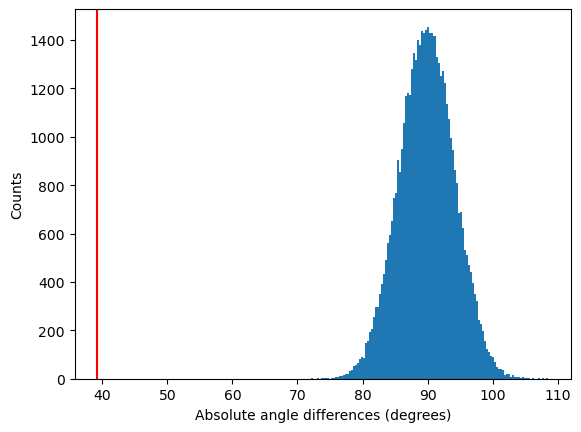

In [53]:
plt.hist(bootstrap_mean_angle_differences_10000 ,bins='auto')
plt.axvline(x = actual_mean_absolute_angle_diff, color = 'r')
plt.xlabel('Absolute angle differences (degrees)')
plt.ylabel('Counts')
plt.show()

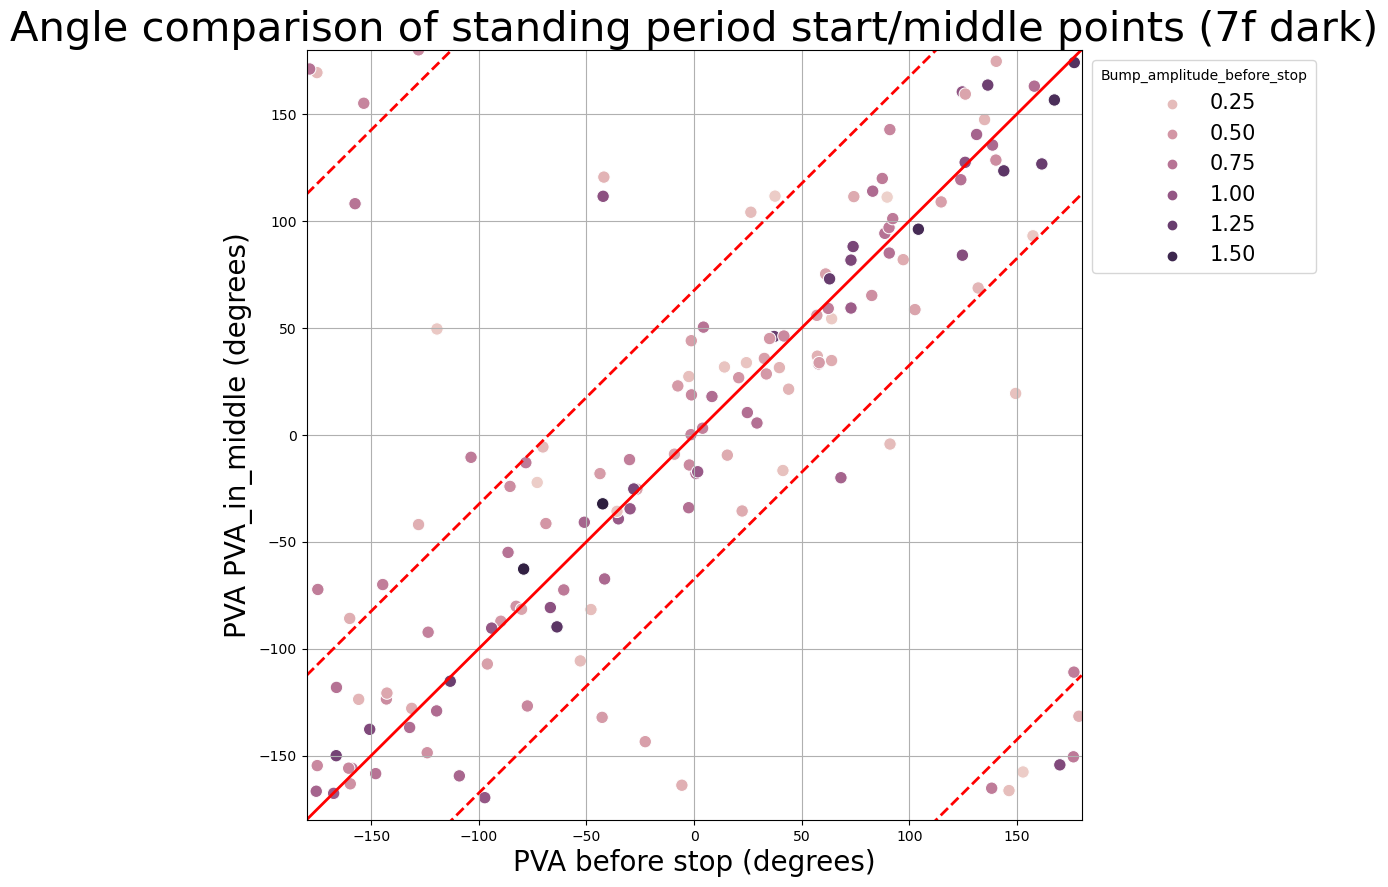

In [54]:
plt.figure(figsize= (10,10))
cmap = sns.cubehelix_palette(rot = -.2, as_cmap = True)
snsplot = sns.scatterplot(data = persistence_data_pooled, x='PVA_before_stop', y='PVA_in_middle', hue = 'bump_amplitude_before_stop', s =80)
snsplot.legend(bbox_to_anchor= (1,1), title = 'Bump_amplitude_before_stop', fontsize = 15)
X_plot = np.linspace(-180, 180, 100)
Y_plot = X_plot
plt.plot(X_plot,Y_plot, color='r', linewidth =2)
plt.plot(X_plot,Y_plot + 67.5, color='r', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot - 67.5, color='r', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot + 292.5, color='r', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot - 292.5, color='r', linestyle ='--', linewidth =2)
plt.ylim(-180, 180)
plt.xlim(-180, 180)
plt.title('Angle comparison of standing period start/middle points (7f dark)', fontsize =30)
plt.ylabel('PVA PVA_in_middle (degrees)',fontsize= 20)
plt.xlabel('PVA before stop (degrees)',fontsize= 20)
#plt.setp(snsplot.get_legend().get_texts(), fontsize = 10)
plt.grid()
plt.show()

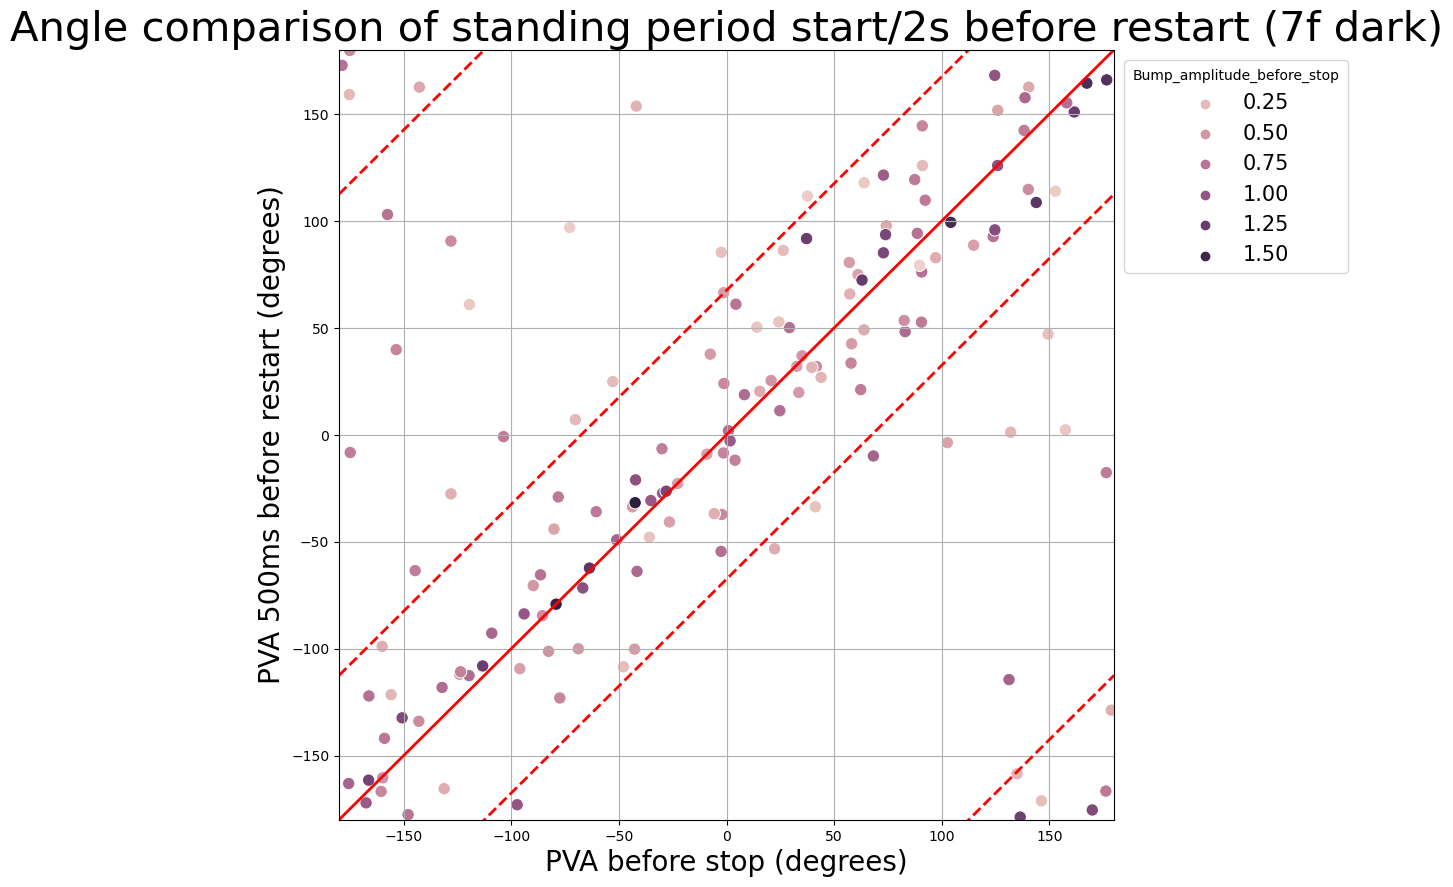

In [55]:
plt.figure(figsize= (10,10))
cmap = sns.cubehelix_palette(rot = -.2, as_cmap = True)
snsplot = sns.scatterplot(data = persistence_data_pooled, x='PVA_before_stop', y='PVA_2s_before_restart', hue = 'bump_amplitude_before_stop', s =80)
snsplot.legend(bbox_to_anchor= (1,1), title = 'Bump_amplitude_before_stop', fontsize = 15)
X_plot = np.linspace(-180, 180, 100)
Y_plot = X_plot
plt.plot(X_plot,Y_plot, color='r', linewidth =2)
plt.plot(X_plot,Y_plot + 67.5, color='r', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot - 67.5, color='r', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot + 292.5, color='r', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot - 292.5, color='r', linestyle ='--', linewidth =2)
plt.ylim(-180, 180)
plt.xlim(-180, 180)
plt.title('Angle comparison of standing period start/2s before restart (7f dark)', fontsize =30)
plt.ylabel('PVA 500ms before restart (degrees)',fontsize= 20)
plt.xlabel('PVA before stop (degrees)',fontsize= 20)
#plt.setp(snsplot.get_legend().get_texts(), fontsize = 10)
plt.grid()
plt.show()

In [56]:
persistence_data_pooled['angle difference start/middle'] = calculate_angle_difference_between_two_time_point(persistence_data_pooled['PVA_before_stop'],persistence_data_pooled['PVA_in_middle'])

In [57]:
persistence_data_pooled['angle difference start/end'] = calculate_angle_difference_between_two_time_point(persistence_data_pooled['PVA_before_stop'],persistence_data_pooled['PVA_at_restart'])

In [58]:
persistence_data_pooled

FlyTrial        Genotype TrialType  Period_duration  PVA_before_stop   
0    TQfly020-004  R60D05>GCaMP7f        cl          8.63612       152.779284  \
1    TQfly020-004  R60D05>GCaMP7f        cl          4.31806       -86.439229   
2    TQfly020-004  R60D05>GCaMP7f        cl         37.35624       -85.523872   
3    TQfly020-004  R60D05>GCaMP7f        cl          5.92478        -1.320021   
4    TQfly020-004  R60D05>GCaMP7f        cl          6.92898       104.161500   
..            ...             ...       ...              ...              ...   
144  TQfly006-004  R60D05>GCaMP7f        cl         20.02497       -42.736785   
145  TQfly006-004  R60D05>GCaMP7f        cl         23.74218       138.222288   
146  TQfly006-004  R60D05>GCaMP7f        cl         15.58830      -142.700005   
147  TQfly006-004  R60D05>GCaMP7f        cl         13.07019      -131.178308   
148  TQfly006-004  R60D05>GCaMP7f        cl         88.01394       149.353316   

     PVA_at_restart  PVA_100ms_before_restart  PVA_500ms_before_restart   
0        129.954677                156.596466                 16.232703  \
1        -68.797495                -74.962955                -69.155067   
2        -64.215069                -65.600353                -34.962486   
3         32.400089                 40.185377                 39.926749   
4        103.727001                105.218979                104.758681   
..              ...                       ...                       ...   
144      -77.586427                -48.538572                -72.358036   
145     -163.702983               -173.821122               -166.495025   
146     -149.362476               -157.569945                -99.942970   
147     -150.006876               -143.112831                177.899859   
148     -118.466666                 55.608811                 50.969139   

     PVA_in_middle  PVA_2s_before_restart  ...  bump_amplitude_at_restart   
0      -157.673166             113.858629  ...                   0.120168  \
1       -55.013859             -65.503918  ...                   0.494114   
2       -24.163843             -84.568892  ...                   0.124029   
3        43.955119              66.408276  ...                   0.502485   
4        96.081117              99.294985  ...                   0.958967   
..             ...                    ...  ...                        ...   
144    -132.141746            -100.250723  ...                   0.254206   
145    -165.264493             142.279049  ...                   0.238209   
146    -120.791635             162.518259  ...                   0.301008   
147    -127.937979            -165.489649  ...                   0.240625   
148      19.296692              47.018918  ...                   0.105966   

     bump_amplitude_100ms_before_restart  bump_amplitude_500ms_before_restart   
0                               0.118655                             0.180550  \
1                               0.514409                             0.639346   
2                               0.107755                             0.185554   
3                               0.438824                             0.672808   
4                               1.017992                             1.064665   
..                                   ...                                  ...   
144                             0.227604                             0.197644   
145                             0.248334                             0.241640   
146                             0.278209                             0.304520   
147                             0.240952                             0.214188   
148                             0.220290                             0.319481   

     bump_amplitude_in_middle  bump_amplitude_2s_before_restart   
0                    0.139993                          0.102664  \
1                    0.587214                          0.447535   
2                    0.201707       

In [59]:
persistence_data_pooled.to_csv('/home/tianhaoqiu/Documents/persistence_data_pooled_EPG_7f_PB_cl.csv',encoding = 'utf-8', index=False)